# Naive Bayes Cornell Data Set E2E + 5 Extended

In [12]:

import os
import pandas as pd
from pathlib import Path
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
print("Ready.")

Ready.


## 1) Dataset Baru (10 review)

In [13]:
BASE_DIR = Path("/Users/muhammadkharisazhar/Documents/Binus/ML/TK4/data")

CORNELL_POS = BASE_DIR / "cornell/pos"
CORNELL_NEG = BASE_DIR / "cornell/neg"
EXT_POS = BASE_DIR / "extended/pos_new"
EXT_NEG = BASE_DIR / "extended/neg_new"

def read_reviews_from_folder(folder_path: Path, label: str):
    reviews = []
    for file in sorted(folder_path.glob("*.txt")):
        with open(file, "r", encoding="utf-8", errors="ignore") as f:
            text = f.read().strip()
        reviews.append({"opinion_id": file.stem, "text": text, "label": label})
    return reviews

pos_reviews = read_reviews_from_folder(CORNELL_POS, "Pos")
neg_reviews = read_reviews_from_folder(CORNELL_NEG, "Neg")

pos_ext = read_reviews_from_folder(EXT_POS, "Pos")
neg_ext = read_reviews_from_folder(EXT_NEG, "Neg")

all_reviews = pos_reviews + neg_reviews + pos_ext + neg_ext
df = pd.DataFrame(all_reviews)
print(f"Total review: {len(df)} ({df['label'].value_counts().to_dict()})")
df.head()

OUT = Path("outputs")
OUT.mkdir(exist_ok=True, parents=True)
raw_path = OUT / "combined_reviews_dataset.csv"

df.to_csv(OUT / "combined_reviews_dataset.csv", index=False)
print("✅ Dataset saved to:", OUT / "combined_reviews_dataset.csv")
print(f"Total review: {len(df)} ({df['label'].value_counts().to_dict()})")


Total review: 2010 ({'Pos': 1005, 'Neg': 1005})
✅ Dataset saved to: outputs/combined_reviews_dataset.csv
Total review: 2010 ({'Pos': 1005, 'Neg': 1005})


## 2) Bag-of-Words (binary)

In [14]:
vectorizer = CountVectorizer(stop_words='english', binary=True, min_df=2)
X = vectorizer.fit_transform(df["text"])
feature_names = vectorizer.get_feature_names_out()

bow_df = pd.DataFrame(X.toarray(), columns=feature_names)
bow_df.insert(0, "opinion_id", df["opinion_id"])
bow_df["label"] = df["label"]

bow_path = OUT / "combined_bow_binary.csv"
bow_df.to_csv(bow_path, index=False)
print("✅ Bag-of-Words saved:", bow_path)


✅ Bag-of-Words saved: outputs/combined_bow_binary.csv


## 3) 3 Kata Paling Diskriminatif (log-odds NB)

In [15]:

clf_tmp = MultinomialNB(alpha=1.0).fit(X, df['label'])
classes_ = list(clf_tmp.classes_)
pos_idx, neg_idx = classes_.index('Pos'), classes_.index('Neg')
log_odds = clf_tmp.feature_log_prob_[pos_idx] - clf_tmp.feature_log_prob_[neg_idx]
top3_idx = np.argsort(np.abs(log_odds))[-3:][::-1]
sel_words = np.array(feature_names)[top3_idx]
presence = X[:, top3_idx].toarray().T
presence_table = pd.DataFrame(
    presence,
    index=[f"Word {i+1} ({w})" for i, w in enumerate(sel_words)],
    columns=[str(i) for i in range(1, len(df) + 1)] 
)

label_row = pd.DataFrame([df['label'].tolist()], index=['Label'], columns=presence_table.columns)
sample_table = pd.concat([presence_table, label_row], axis=0)
sample_table

presence_path = OUT / "sample_3word_presence_table.csv"
sample_table.to_csv(presence_path)
print("✅ 3-word presence table saved:", presence_path)

✅ 3-word presence table saved: outputs/sample_3word_presence_table.csv


## 4) Train/Test Naive Bayes + Evaluasi

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, df["label"], test_size=0.2, random_state=42, stratify=df["label"]
)

clf = MultinomialNB(alpha=1.0).fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Prediksi per review
pred_df = pd.DataFrame({
    "opinion_id": df.iloc[y_test.index]["opinion_id"],
    "true_label": y_test.values,
    "predicted_label": y_pred
})
pred_path = OUT / "nb_predictions.csv"
pred_df.to_csv(pred_path, index=False)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=["Neg", "Pos"])
cm_df = pd.DataFrame(cm, index=["Neg (true)", "Pos (true)"], columns=["Neg (pred)", "Pos (pred)"])
cm_path = OUT / "nb_confusion_matrix.csv"
cm_df.to_csv(cm_path)

# Report & CV
report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report).transpose()
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(MultinomialNB(alpha=1.0), X, df["label"], cv=skf, scoring="accuracy")

metrics_df = pd.DataFrame({
    "metric": ["holdout_accuracy"] + [f"cv_acc_fold_{i+1}" for i in range(5)] + ["cv_acc_mean", "cv_acc_std"],
    "value": [accuracy_score(y_test, y_pred)] + list(cv_scores) + [cv_scores.mean(), cv_scores.std()]
})

report_path = OUT / "nb_classification_report.csv"
metrics_path = OUT / "nb_metrics.csv"
report_df.to_csv(report_path)
metrics_df.to_csv(metrics_path, index=False)

print("✅ Predictions:", pred_path)
print("✅ Confusion matrix:", cm_path)
print("✅ Classification report:", report_path)
print("✅ Metrics:", metrics_path)


✅ Predictions: outputs/nb_predictions.csv
✅ Confusion matrix: outputs/nb_confusion_matrix.csv
✅ Classification report: outputs/nb_classification_report.csv
✅ Metrics: outputs/nb_metrics.csv


## 5) 5-fold Cross-Validation

In [17]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(MultinomialNB(alpha=1.0), X, df['label'], cv=skf, scoring='accuracy')
pd.DataFrame({'cv_acc': cv_scores, 'fold': range(1,6)}).assign(mean=cv_scores.mean(), std=cv_scores.std())

,cv_acc,fold,mean,std
0,0.835821,1,0.828856,0.01393
1,0.818408,2,0.828856,0.01393
2,0.833333,3,0.828856,0.01393
3,0.848259,4,0.828856,0.01393
4,0.808458,5,0.828856,0.01393


## 6) Export BoW Versi Long


In [20]:
# --- Step 5: Export BoW Long (robust terhadap bentrok nama kolom) ---

# Pilih nama kolom value yang dijamin tidak bentrok
value_col = "__presence__"
while value_col in bow_df.columns:
    value_col += "_"

bow_long = (
    bow_df
    .melt(
        id_vars=["opinion_id", "label"],
        var_name="term",
        value_name=value_col
    )
    .query(f"{value_col} == 1")
    .drop(columns=[value_col])
    .sort_values(["opinion_id", "term"])
)

bow_long_path = OUT / "combined_bow_long.csv"
bow_long.to_csv(bow_long_path, index=False)
print("✅ Long-form BoW saved:", bow_long_path)


✅ Long-form BoW saved: outputs/combined_bow_long.csv


In [22]:
## 7) Output Summarize

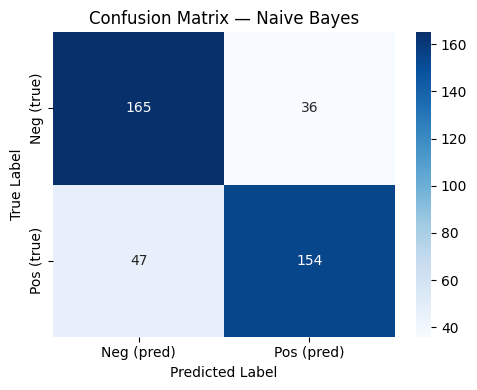

/var/folders/s8/1p9jdxbn3lv925rpbyxf7c8w0000gq/T/ipykernel_20289/3531840691.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="label", palette="Set2")


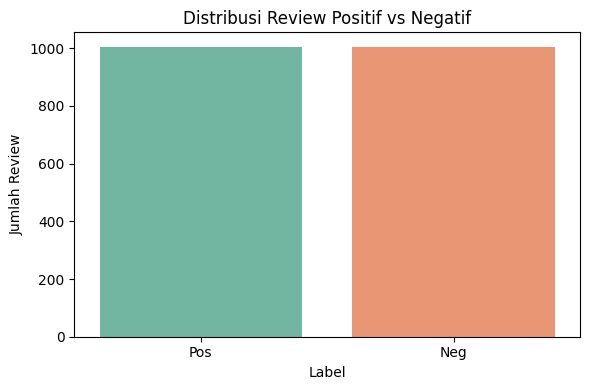

/var/folders/s8/1p9jdxbn3lv925rpbyxf7c8w0000gq/T/ipykernel_20289/3531840691.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=fold_metrics, x="metric", y="value", palette="coolwarm")


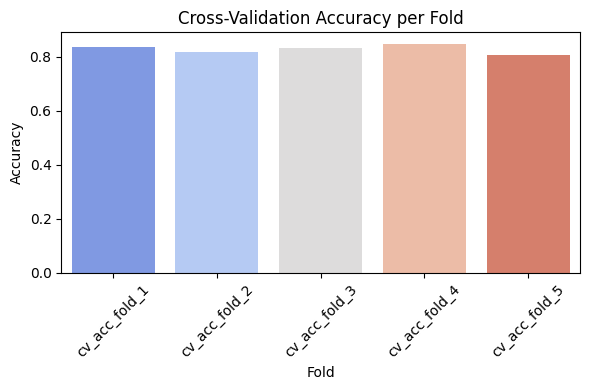

/var/folders/s8/1p9jdxbn3lv925rpbyxf7c8w0000gq/T/ipykernel_20289/3531840691.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_pos_vals, y=top_pos_terms, palette="Greens_r")


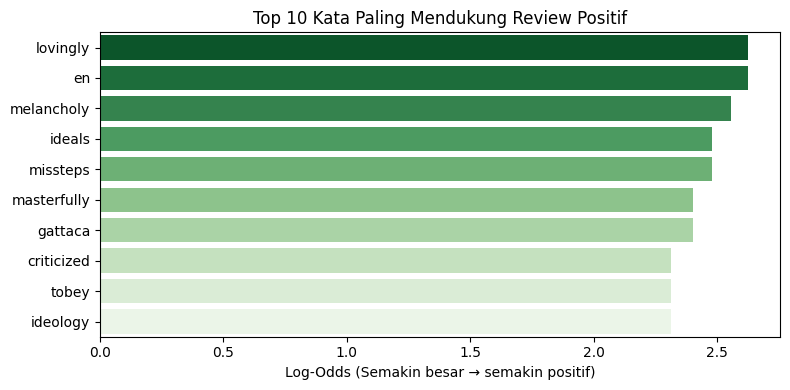

/var/folders/s8/1p9jdxbn3lv925rpbyxf7c8w0000gq/T/ipykernel_20289/3531840691.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_neg_vals, y=top_neg_terms, palette="Reds")


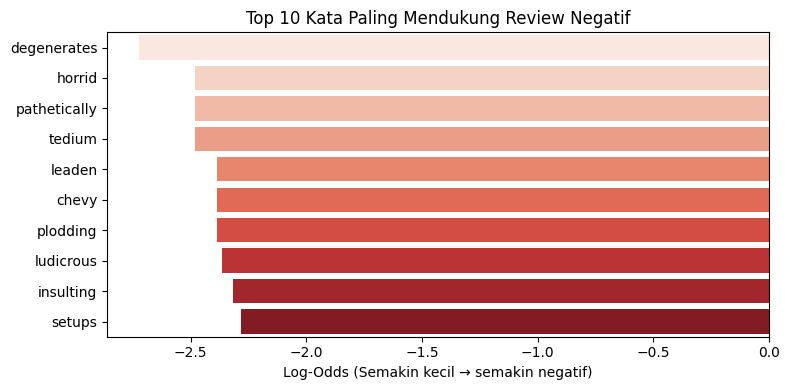

In [23]:
OUT = Path("outputs")

# 1️⃣ — Visualisasi Confusion Matrix
cm_df = pd.read_csv(OUT / "nb_confusion_matrix.csv", index_col=0)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix — Naive Bayes")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# 2️⃣ — Distribusi Label Asli (Cornell + Extended)
df = pd.read_csv(OUT / "combined_reviews_dataset.csv")
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="label", palette="Set2")
plt.title("Distribusi Review Positif vs Negatif")
plt.xlabel("Label")
plt.ylabel("Jumlah Review")
plt.tight_layout()
plt.show()

# 3️⃣ — Akurasi Cross Validation per Fold
metrics_df = pd.read_csv(OUT / "nb_metrics.csv")
fold_metrics = metrics_df[metrics_df["metric"].str.contains("cv_acc_fold")]
plt.figure(figsize=(6, 4))
sns.barplot(data=fold_metrics, x="metric", y="value", palette="coolwarm")
plt.title("Cross-Validation Accuracy per Fold")
plt.ylabel("Accuracy")
plt.xlabel("Fold")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

k = 10
pos_idx = list(clf_tmp.classes_).index("Pos")
neg_idx = list(clf_tmp.classes_).index("Neg")
log_odds = clf_tmp.feature_log_prob_[pos_idx] - clf_tmp.feature_log_prob_[neg_idx]
feature_names = np.array(vectorizer.get_feature_names_out())

# ambil top 10 Positif dan Negatif
top_pos_idx = np.argsort(log_odds)[-k:][::-1]
top_neg_idx = np.argsort(log_odds)[:k]

top_pos_terms = feature_names[top_pos_idx]
top_neg_terms = feature_names[top_neg_idx]
top_pos_vals = log_odds[top_pos_idx]
top_neg_vals = log_odds[top_neg_idx]

plt.figure(figsize=(8, 4))
sns.barplot(x=top_pos_vals, y=top_pos_terms, palette="Greens_r")
plt.title("Top 10 Kata Paling Mendukung Review Positif")
plt.xlabel("Log-Odds (Semakin besar → semakin positif)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
sns.barplot(x=top_neg_vals, y=top_neg_terms, palette="Reds")
plt.title("Top 10 Kata Paling Mendukung Review Negatif")
plt.xlabel("Log-Odds (Semakin kecil → semakin negatif)")
plt.tight_layout()
plt.show()

